In [542]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import db_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

PLOT_OUT = '/home/vuvietmi/Workspace/tex_autoperp/figures'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [543]:
metric_names = {
    'auc_rnx': '$AUC_{log}RNX$',
    'pearsonr': 'CC',
    'cca_stress': 'CCA',
    'mds_isotonic': 'NMS',
    'sammon_nlm': 'NLM',
    'bic': 'BIC'
}

constraint_names = {
    's_all': '$S_{M+C}$',
    's_ml': '$S_{M}$',
    's_cl': '$S_{C}$'
}

def get_name_by_key(key):
    return {**metric_names, **constraint_names}[key]

dataset_names = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
    'BREAST-CANCER95',
    'MPI',
    'DIABETES'
]

In [544]:
def load_scores(dataset_name, standardized=False):
    # print('Loading scores for ', dataset_name)
    db_name = 'DB_{}'.format(dataset_name)
    constraint_key_name = 'constraints'
    metric_key_name = 'metrics2'

    # load metric scores and sort the record by perplexity
    dfm = db_utils.load_data(db_name, metric_key_name)
    dfm = dfm.sort_values('perp')
    # remove record with max_perp
    dfm = dfm[dfm.perp < dfm.perp.max()]

    # use opposite value of 3 unbounded metrics
    dfm.cca_stress *= -1
    dfm.mds_isotonic *= -1
    dfm.sammon_nlm *= -1
    
    # use opposite value of BIC-based criteria in Cao et al.
    dfm.bic *= -1    
    
    # load constraint scores
    dfc = db_utils.load_data(db_name, constraint_key_name)
    dfc = dfc.loc[:, dfc.columns != 'reproduce_seed']
    dfc = dfc[dfc.perp < dfc.perp.max()]
    
#     # only work with `n_constraints > 5`
#     dfc = dfc[dfc.n_constraints > 5]
#     # remove record with max_perp
#     dfc = dfc[dfc.perp < dfc.perp.max()]
#     # group by perplexity
#     dfc = dfc.groupby('perp').mean()

    # only work with 50 constraints
    dfc = dfc[dfc.n_constraints == 50]
    dfc = dfc.groupby('perp').first()

    perps = dfm.perp
    assert 0.0 == np.sum(perps - dfc.index)
    
    if standardized:
        # after getting the index (perp column), do standardize
        dfm = (dfm - dfm.mean()) / dfm.std()
        dfc = (dfc - dfc.mean()) / dfc.std()
    
    return perps, dfm, dfc

### Plot KL-loss by perplexity

MNIST-SMALL 53.33977182105158
COIL20 17.861747114756763


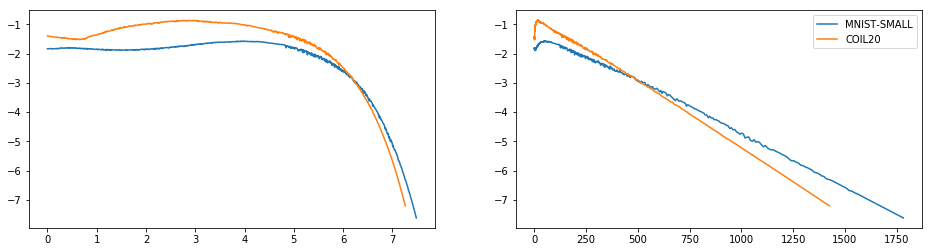

In [545]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
for dataset_name in dataset_names[:2]:
    perps, dfm, dfc = load_scores(dataset_name, standardized=False)
    idx = dfm.bic.idxmax()
    print(dataset_name, perps[idx])
    axes[0].plot(np.log(perps), dfm.bic, label=dataset_name)
    axes[1].plot(perps, dfm.bic, label=dataset_name)
    
axes[1].legend()

In [530]:
perps, dfm, dfc = load_scores(dataset_name='COIL20', standardized=False)
dfm.bic.idxmax()

121

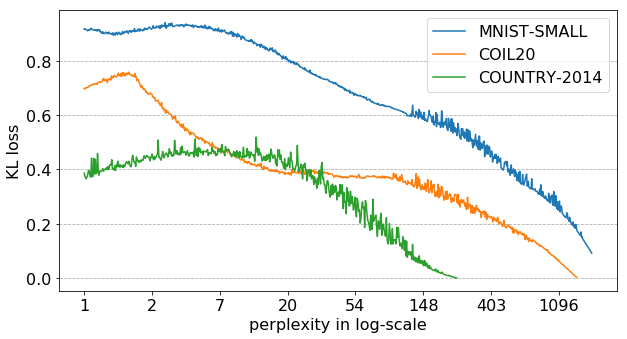

In [549]:
from matplotlib.ticker import FuncFormatter

def log_e_format(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return int(x)

some_dataset_names = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
#     'BREAST-CANCER95',
#     'MPI',
#     'DIABETES'
]

fig, ax = plt.subplots(figsize=(9,5))
markers = ['*', 's', 'o', '*', 's', 'o']
for i, dataset_name in enumerate(some_dataset_names):
    perps, dfm, dfc = load_scores(dataset_name, standardized=False)
    ax.semilogx(perps, dfm.loss, label=dataset_name, basex=np.e,)
                #marker=markers[i], markevery=[-1], markersize=8)
    ax.xaxis.set_major_formatter(FuncFormatter(log_e_format))
    ax.set_xlabel('perplexity in log-scale')
    ax.set_ylabel('KL loss')

ax.yaxis.grid(linestyle='--')
plt.legend()
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.savefig('{}/klloss_all.pdf'.format(PLOT_OUT))

### Visually compare $S_{M+C}, S_{M}, S_{C}$ with the metric scores

From the table of cosine distances between metric and constraint scores:
+ For all datasets, $S_{M+C}$ is always close to $AUC_{log}RNX$.
+ For (all) datasets, $S_M$ is always close to $CC$.
+ For (all) datasets, $S_C$ is _always_ close to $CCA$ and $nMDS$.
+ Surprisingly, $S_{M+C}$ and $S_M$ only agree with the bounded metric $AUC_{log}RNX$ and $CC$ but never with the unbounded metric $CCA, nMDS$ and $NLM$. In contrast, $S_C$ tends to agree more with the unbounded metrics.
    
![]('./plots/cosine_distance.png')

In [531]:
colors = {
    'auc_rnx': "#5574a6",
    'pearsonr': "#329262",
    'cca_stress': "#651067",
    'mds_isotonic': "#8b0707",
    'sammon_nlm': '#e67300',
    's_all': "#ff9900",
    's_ml': "#3366cc",
    's_cl':"#dc3912",
    'bic': '#22aa99'
}

In [532]:
from matplotlib.ticker import FuncFormatter

def exp_format(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return int(np.exp(x))

In [533]:
# from scipy.spatial.distance import cosine

font_size = 16
plt.rcParams.update({'font.size': font_size})

from itertools import cycle

def _plot_lines_by_keys(dataset_name, metric_keys, constraint_keys, axis, marker_pos, last_row=False):
    perps, dfm, dfc = load_scores(dataset_name, standardized=False)
    x_axis = np.log(perps)
    
    # each key has its own range value, so plot each key on it own y-axis
    def _plot_lines(df, keys, markers, marker_pos):
        lines = []
        for i, key_name in enumerate(keys):
            ax = axis.twinx()
            line, = ax.plot(x_axis, df[key_name],# linewidth=1,
                            color=colors[key_name],
                            label=get_name_by_key(key_name),
                            marker=next(markers),
                            markersize=8, markevery=[next(marker_pos)],)
            ax.get_yaxis().set_ticks([])
            ax.xaxis.set_major_formatter(FuncFormatter(exp_format))
            
            lines.append(line)
        return lines
    
    lines = []
    markers = cycle(['', '', ''])#['*', 'o', 's'])
    marker_pos = cycle(marker_pos)
    lines += _plot_lines(dfm, metric_keys, markers, marker_pos)
    lines += _plot_lines(dfc, constraint_keys, markers, marker_pos)
    axis.set_title(dataset_name)
    axis.yaxis.grid(True, linestyle='--')
#     axis.get_yaxis().set_visible(False)
    axis.set_yticklabels([])
    axis.tick_params('y', length=0)

    # axis.xaxis.grid(True, linestyle='--')
    
    if last_row:
        axis.set_xlabel('$perplexity$ in log-scale')

    return lines

In [534]:
def plot_lines_by_keys(metric_keys, constraint_keys, marker_pos, legend_loc='lower center'):
    line_styles=['-', '-.', '--', ':'] # not used
    fig, ax = plt.subplots(3, 2, figsize=(14, 12))

    for i, dataset_name in enumerate(dataset_names):
        r, c = i // 2, i % 2
        lines = _plot_lines_by_keys(dataset_name, metric_keys, constraint_keys, ax[r][c], marker_pos, last_row=r==2)

    plt.tight_layout()
    ax[0][0].legend(handles=lines, loc=legend_loc)

### Plot $S_{M+C}$ vs. $AUC_{log}RNX$

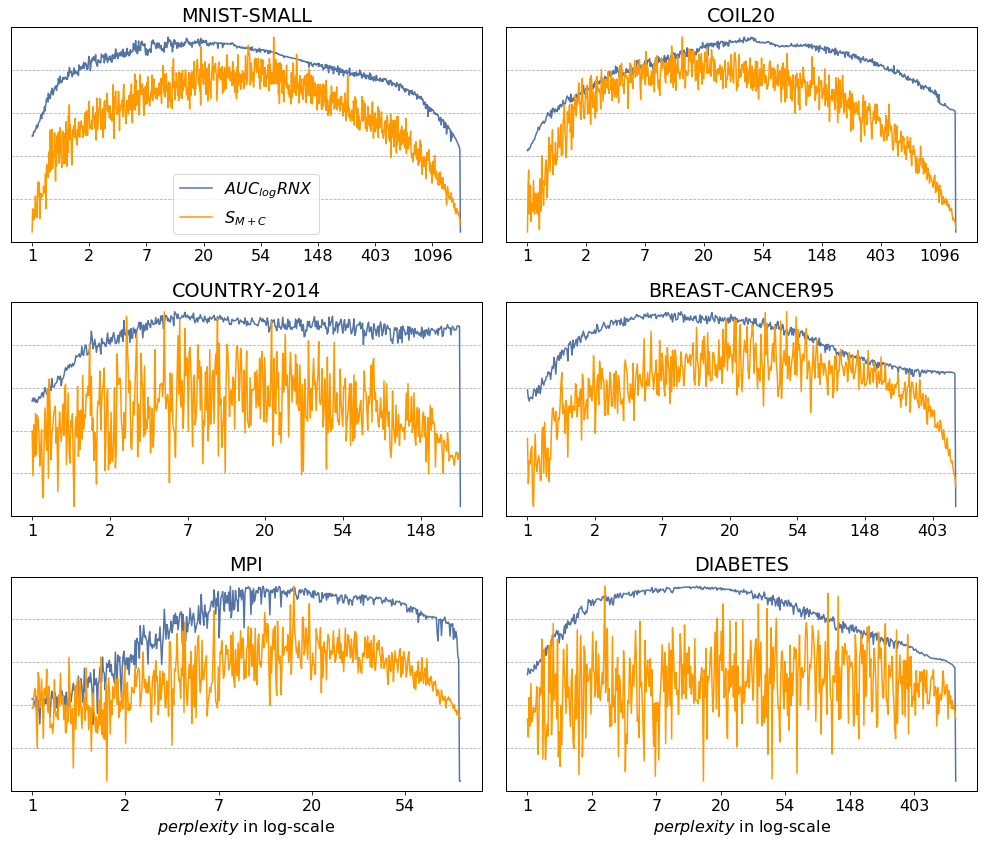

In [535]:
plot_lines_by_keys(['auc_rnx'], ['s_all'], marker_pos=[0, -1])
plt.savefig('./plots/sall_auc.pdf')

### Plot $S_{C}$ vs. $BIC$

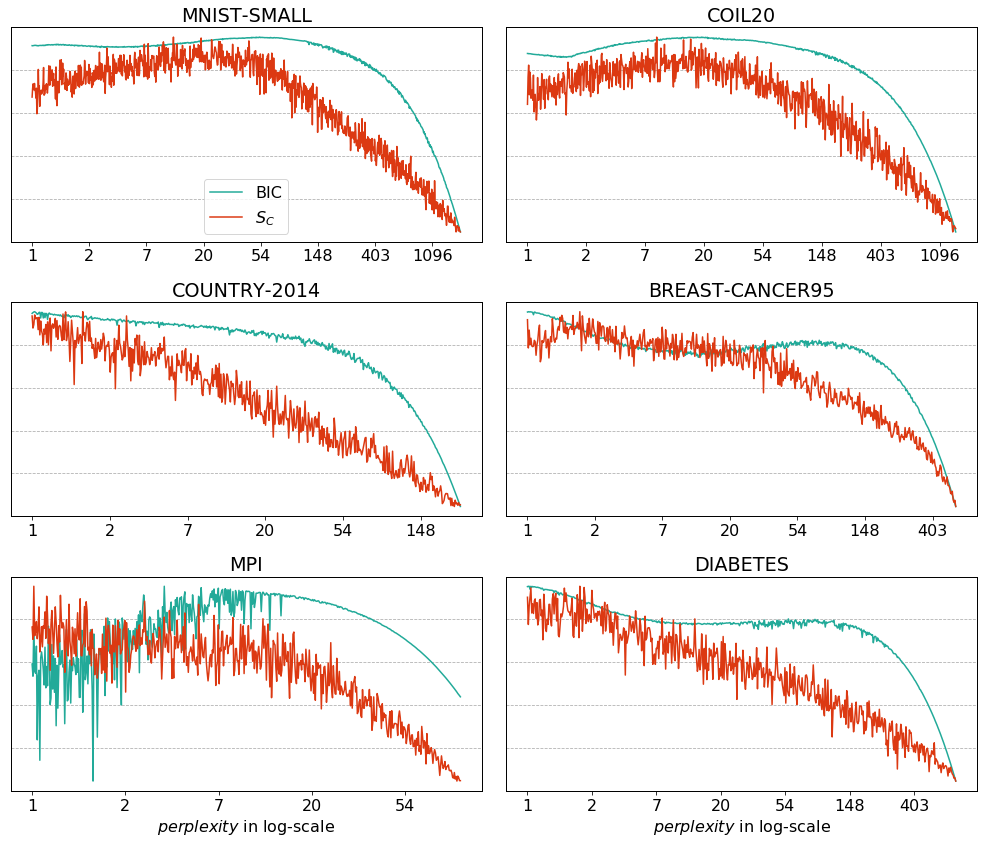

In [541]:
plot_lines_by_keys(['bic'], ['s_cl'], marker_pos=[-80, -40])
plt.savefig('./plots/scl_bic.pdf')

### Plot $S_{M}$ vs. Corr. Coeff.

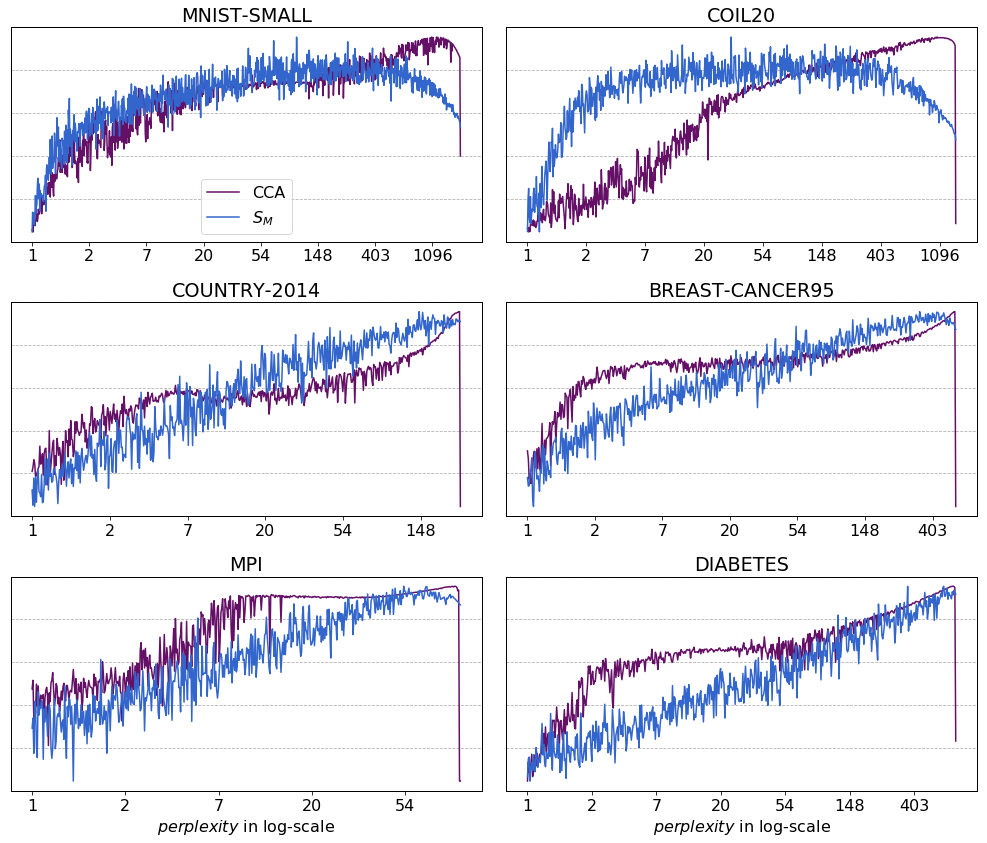

In [540]:
plot_lines_by_keys(['cca_stress'], ['s_ml'], marker_pos=[-16, -60], legend_loc=8)
plt.savefig('./plots/sml_cca.pdf')

### Plot $S_C$ vs. $CCA$ and Non-metric MDS Stress

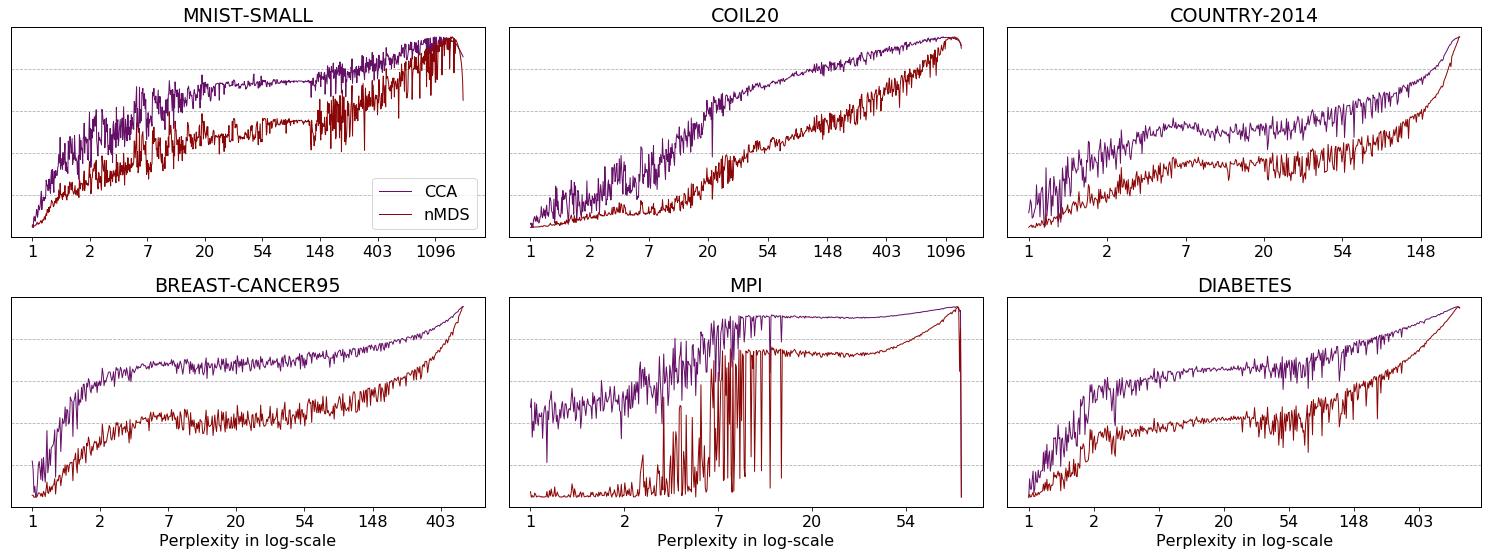

In [336]:
plot_lines_by_keys(['cca_stress', 'mds_isotonic'], [], legend_loc=4)

### Plot $S_M, S_C$ vs. Sammon's Non-linear mapping

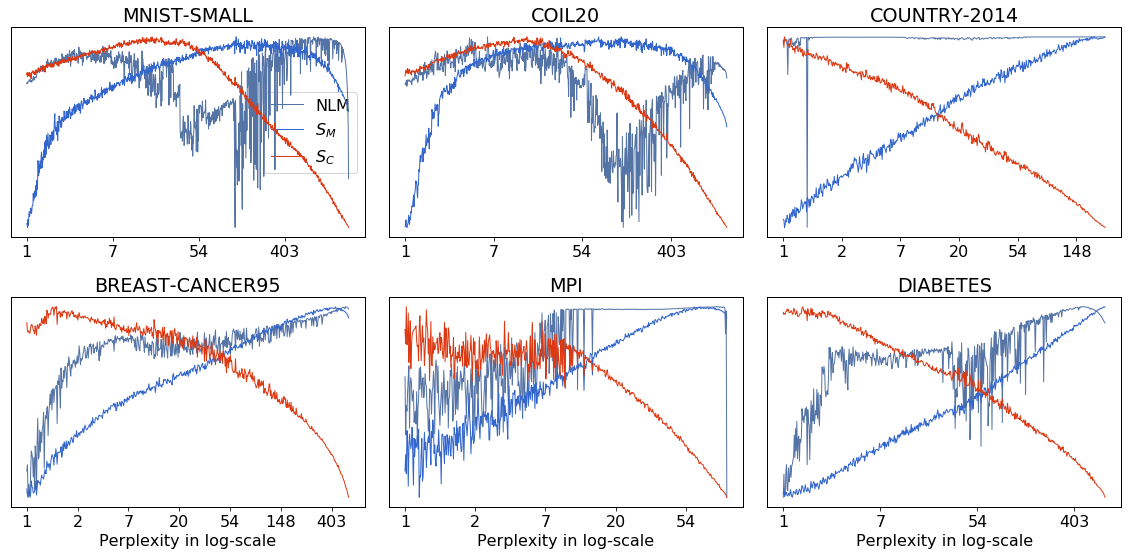

In [255]:
plot_lines_by_keys(['sammon_nlm'], ['s_ml', 's_cl'], legend_loc=5)